In [9]:
import numpy as np
import pandas as pd

from pyinform.dist import Dist
from statsmodels.tsa.arima_process import ArmaProcess
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

from scipy.stats import entropy

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.stattools import pacf 
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mutual_info_score

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns

### $AR(1)$ 
#### $S_t = \mu + \phi_1 S_{t-1} + \epsilon_t$

In [60]:
np.random.seed(42)

ar = np.array([1, -0.9]) # MU(constant)=1, PHI=0.9 (MOMENTUM)
ma = np.array([1])

process = ArmaProcess(ar, ma)
series = process.generate_sample(1000, )

In [61]:
print(f'mu: {np.mean(series)}')
print(f'sigma: {np.std(series)}')
print(f'sigma2: {np.var(series)}')

mu: 0.19626089593974705
sigma: 2.241191499090931
sigma2: 5.022939335597455


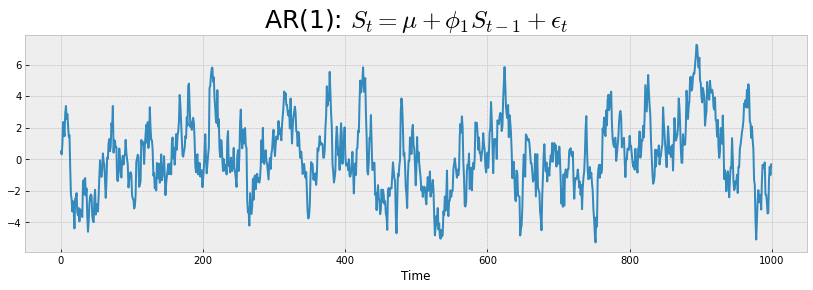

In [62]:
plt.figure(figsize=(14,4))
plt.title('AR(1): '+'$S_t = \mu + \phi_1 S_{t-1} + \epsilon_t$', fontsize=25)
plt.plot(series)
plt.xlabel('Time')
plt.show()

In [74]:
data = pd.DataFrame({'ar':series})
s_dict = {}
n_series = 5
for s in range(n_series):
    idx = s+1
    name = 'l'+str(idx)
    s_dict[name] = idx
    data[name] = data['ar'].shift(idx)
data.head()

,ar,l1,l2,l3,l4,l5
0,0.496714,NaN,NaN,NaN,NaN,NaN
1,0.308778,0.496714,NaN,NaN,NaN,NaN
2,0.925589,0.308778,0.496714,NaN,NaN,NaN
3,2.356060,0.925589,0.308778,0.496714,NaN,NaN
4,1.886301,2.356060,0.925589,0.308778,0.496714,NaN


In [75]:
data.corr()

,ar,l1,l2,l3,l4,l5
ar,1.000000,0.899631,0.810859,0.731175,0.656544,0.600965
l1,0.899631,1.000000,0.899659,0.810848,0.731196,0.657030
l2,0.810859,0.899659,1.000000,0.899668,0.810788,0.731381
l3,0.731175,0.810848,0.899668,1.000000,0.899701,0.811380
l4,0.656544,0.731196,0.810788,0.899701,1.000000,0.900009
l5,0.600965,0.657030,0.731381,0.811380,0.900009,1.000000


In [76]:
y_series = 'l4'

x = data['ar'].values
y = data[y_series].values

x = x[s_dict[y_series]:]
y = y[s_dict[y_series]:]

In [106]:
state_set = np.arange(4, 16, 2)
state_set

array([ 4,  6,  8, 10, 12, 14])

In [107]:
states = 10

big_correlations = []
big_informations = []

for states in state_set:
    correlations = []
    informations = []
    print(f'States={states}','='*15)
    for serie in s_dict.keys():
        print(f'Serie: {k}')
        x = data['ar'].values
        y = data[serie].values

        x = x[s_dict[serie]:]
        y = y[s_dict[serie]:]

        pxy, xbin, ybin = np.histogram2d(x, y, bins=states)
        joint = pxy/pxy.sum()
        qX = joint.sum(1)
        qY = joint.sum(0)

        hX = entropy(qX, base=2)
        hY = entropy(qY, base=2)

        pX_Y = joint / qY

        hX_Y =  np.sum(qY * np.log2(np.e) * np.apply_along_axis(entropy, 0, pX_Y))

        miXY = hX - hX_Y

        correlations.append(np.corrcoef(x, y)[0,1])
        informations.append(miXY)

        print(f'Corr: {np.corrcoef(x, y)[0,1]:.3f}')
        print(f'H(X): {hX:.3f} bits')
        print(f'H(Y): {hY:.3f} bits')
        print(f'I(X:Y): {miXY:.3f} bits | Reduction in the description of X')
        print(f'Reduction: {miXY / hX :.3f}%')
        print('')
    big_correlations.append(correlations)
    big_informations.append(informations)

States=4 ===============
Serie: l1
Corr: 0.900
H(X): 1.654 bits
H(Y): 1.654 bits
I(X:Y): 0.675 bits | Reduction in the description of X
Reduction: 0.408%

Serie: l1
Corr: 0.811
H(X): 1.655 bits
H(Y): 1.655 bits
I(X:Y): 0.507 bits | Reduction in the description of X
Reduction: 0.306%

Serie: l1
Corr: 0.731
H(X): 1.656 bits
H(Y): 1.656 bits
I(X:Y): 0.366 bits | Reduction in the description of X
Reduction: 0.221%

Serie: l1
Corr: 0.657
H(X): 1.655 bits
H(Y): 1.656 bits
I(X:Y): 0.289 bits | Reduction in the description of X
Reduction: 0.175%

Serie: l1
Corr: 0.601
H(X): 1.655 bits
H(Y): 1.655 bits
I(X:Y): 0.238 bits | Reduction in the description of X
Reduction: 0.144%

States=6 ===============
Serie: l1
Corr: 0.900
H(X): 2.178 bits
H(Y): 2.178 bits
I(X:Y): 0.881 bits | Reduction in the description of X
Reduction: 0.405%

Serie: l1
Corr: 0.811
H(X): 2.179 bits
H(Y): 2.179 bits
I(X:Y): 0.615 bits | Reduction in the description of X
Reduction: 0.283%

Serie: l1
Corr: 0.731
H(X): 2.179 bits
H

In [109]:
summary = pd.DataFrame({'signal':[1,2,3,4,5],
                     'corr':correlations})
for idx, mi in zip(state_set, big_informations):
    name = 'mi_'+str(idx)
    #print(name)
    summary[name] = mi
summary

,signal,corr,mi_4,mi_6,mi_8,mi_10,mi_12,mi_14
0,1,0.899631,0.675435,0.880901,0.978349,1.057149,1.122508,1.142542
1,2,0.810859,0.506574,0.615430,0.684301,0.731750,0.778731,0.800159
2,3,0.731175,0.366231,0.454208,0.503996,0.548921,0.576588,0.616843
3,4,0.656544,0.288908,0.353703,0.382150,0.440051,0.461592,0.476370
4,5,0.600965,0.238324,0.295404,0.313227,0.347814,0.392417,0.406566


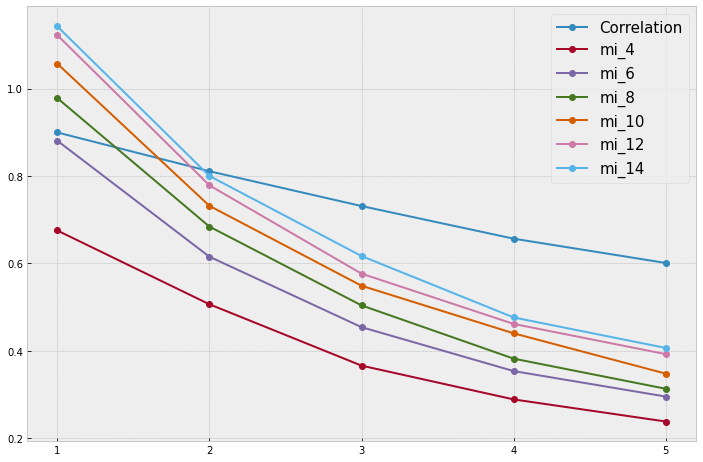

In [114]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(summary['signal'], summary['corr'], marker = 'o', label='Correlation')
for s in summary.columns[2:]:
    ax.plot(summary['signal'], summary[s], marker = 'o', label=s)

ax.set_xticks(summary.signal)
plt.legend(fontsize=15)
plt.show()